<a href="https://colab.research.google.com/github/AarthiThirumavalavan/Deep-Learning/blob/master/child_object_detection_yolov5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
!pip install -r yolov5/requirements.txt  # install dependencies
%cd yolov5

In [ ]:
import torch
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.10.0+cu111 _CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


In [ ]:
from IPython.display import Image
import pandas as pd
import random
import os, glob
import random, shutil
from shutil import copyfile
import utils
display = utils.notebook_init()

YOLOv5 🚀 v6.0-242-gf40854b torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 42.2/78.2 GB disk)


Creating train and test dataset

In [ ]:
LABEL_PATH = '/content/children_violence_yolo'

DATA = '/content/data'

IMAGE = os.path.join(DATA,'images')
LABELS = os.path.join(DATA,'labels')

TRAIN_IMAGE = os.path.join(IMAGE,'train')
TRAIN_LABELS = os.path.join(LABELS,'train')

VAL_IMAGE = os.path.join(IMAGE,'valid')
VAL_LABELS = os.path.join(LABELS,'valid')

In [ ]:
!unrar x "/content/drive/MyDrive/omdena_violence_detection/updated_as_of_2022-02-05/children_violence_yolo.rar" "/content/"

Streaming output truncated to the last 5000 lines.
Extracting  /content/children_violence_yolo/G161__108__0-26__0-30__fix_anonymized__frame-22.txt      10%  OK 
Extracting  /content/children_violence_yolo/G162__108__0-26__0-30__fix_anonymized__frame-23.png      10%  OK 
Extracting  /content/children_violence_yolo/G162__108__0-26__0-30__fix_anonymized__frame-23.txt      10%  OK 
Extracting  /content/children_violence_yolo/G163__108__0-26__0-30__fix_anonymized__frame-24.png      10%  OK 
Extracting  /content/children_violence_yolo/G163__108__0-26__0-30__fix_anonymized__frame-24.txt      10%  OK 
Extracting  /content/children_violence_yolo/G1647__170__0-15__0-17__fix_anonymized__frame-0.png      10%  OK 
Extracting  /content/children_violence_yolo/G1647__170__0-15__0-17__fix_anonymized__frame-0.txt      10%  OK 
Extracting  /content/children_violence_yolo/G1648__170__0-15__0-17__fix_anonymized__frame-1.png      10%  O

In [ ]:
# create label path
annot = glob.glob(os.path.join(LABEL_PATH ,'*.txt'))

# # extract list of annotatoin files
# annot = []

# print('Showing the list of ignored annotation folders')
# for f in files:
#   an_file = glob.glob(os.path.join(f, '*.txt'))
#   if len(an_file)==0:
#     print(f)
#   annot.extend(an_file)

print(f'Number of annotation files {len(annot)}')


Number of annotation files 2861


In [ ]:
os.mkdir(DATA)
os.mkdir(IMAGE)
os.mkdir(LABELS)


os.mkdir(TRAIN_IMAGE)
os.mkdir(TRAIN_LABELS)

os.mkdir(VAL_IMAGE)
os.mkdir(VAL_LABELS)



valid_ann = random.sample(annot, 500)

In [ ]:
for i in annot:
  img = str.replace(i,'.txt','.png')
  if i in valid_ann:
    shutil.copy(i, VAL_LABELS)
    shutil.copy(img,VAL_IMAGE)
  else:
    shutil.copy(i, TRAIN_LABELS)
    shutil.copy(img,TRAIN_IMAGE)

In [ ]:
with open('/content/new_train_yaml', 'w+') as file:
    file.write(
        """
        # parameters
        nc: 2  # number of classes
        depth_multiple: 0.33  # model depth multiple
        width_multiple: 0.50  # layer channel multiple

        # anchors
        anchors:
          - [10,13, 16,30, 33,23]  # P3/8
          - [30,61, 62,45, 59,119]  # P4/16
          - [116,90, 156,198, 373,326]  # P5/32

        # YOLOv5 backbone
        backbone:
          # [from, number, module, args]
          [[-1, 1, Focus, [64, 3]],  # 0-P1/2
           [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
           [-1, 3, BottleneckCSP, [128]],
           [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
           [-1, 9, BottleneckCSP, [256]],
           [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
           [-1, 9, BottleneckCSP, [512]],
           [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
           [-1, 1, SPP, [1024, [5, 9, 13]]],
           [-1, 3, BottleneckCSP, [1024, False]],  # 9
          ]

        # YOLOv5 head
        head:
          [[-1, 1, Conv, [512, 1, 1]],
           [-1, 1, nn.Upsample, [None, 2, 'nearest']],
           [[-1, 6], 1, Concat, [1]],  # cat backbone P4
           [-1, 3, BottleneckCSP, [512, False]],  # 13

           [-1, 1, Conv, [256, 1, 1]],
           [-1, 1, nn.Upsample, [None, 2, 'nearest']],
           [[-1, 4], 1, Concat, [1]],  # cat backbone P3
           [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

           [-1, 1, Conv, [256, 3, 2]],
           [[-1, 14], 1, Concat, [1]],  # cat head P4
           [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

           [-1, 1, Conv, [512, 3, 2]],
           [[-1, 10], 1, Concat, [1]],  # cat head P5
           [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

           [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
          ]
        """
    )

In [ ]:
with open('/content/new_data_yaml', 'w+') as file:
    file.write(
        """
        train: /content/data/images/train
        val: /content/data/images/valid

        nc: 2
        names: ['caregiver','child']
        """
    )

In [ ]:


%%time
!python train.py --img 400 --batch 16 --epochs 10 --data '/content/new_data_yaml' --cfg '/content/new_train_yaml' --weights '/content/yolov5/runs/train/child_detector/weights/best.pt' --name child_detector --nosave --cache



train: weights=/content/yolov5/runs/train/child_detector/weights/best.pt, cfg=/content/new_train_yaml, data=/content/new_data_yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=10, batch_size=16, imgsz=400, rect=False, resume=False, nosave=True, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=child_detector, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-242-gf40854b torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.

In [ ]:
!python detect.py --source /content/data/images/valid --weights '/content/yolov5/runs/train/child_detector2/weights/best.pt' --img 416 --conf 0.5 --save-txt

detect: weights=['/content/yolov5/runs/train/child_detector2/weights/best.pt'], source=/content/data/images/valid, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-242-gf40854b torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model Summary: 232 layers, 7249215 parameters, 0 gradients, 16.8 GFLOPs
image 1/500 /content/data/images/valid/G1108__142__0-42__0-48__fix_anonymized__frame-64.png: 256x416 2 childs, Done. (0.026s)
image 2/500 /content/data/images/valid/G1114__142__0-42__0-48__fix_anonymized__frame-9.png: 256x416 1 caregiver, Done. (0.026s)
image 3/500 /content/data/images/valid/G1124__144__0-27__0-33__fix_anonymized__frame-1

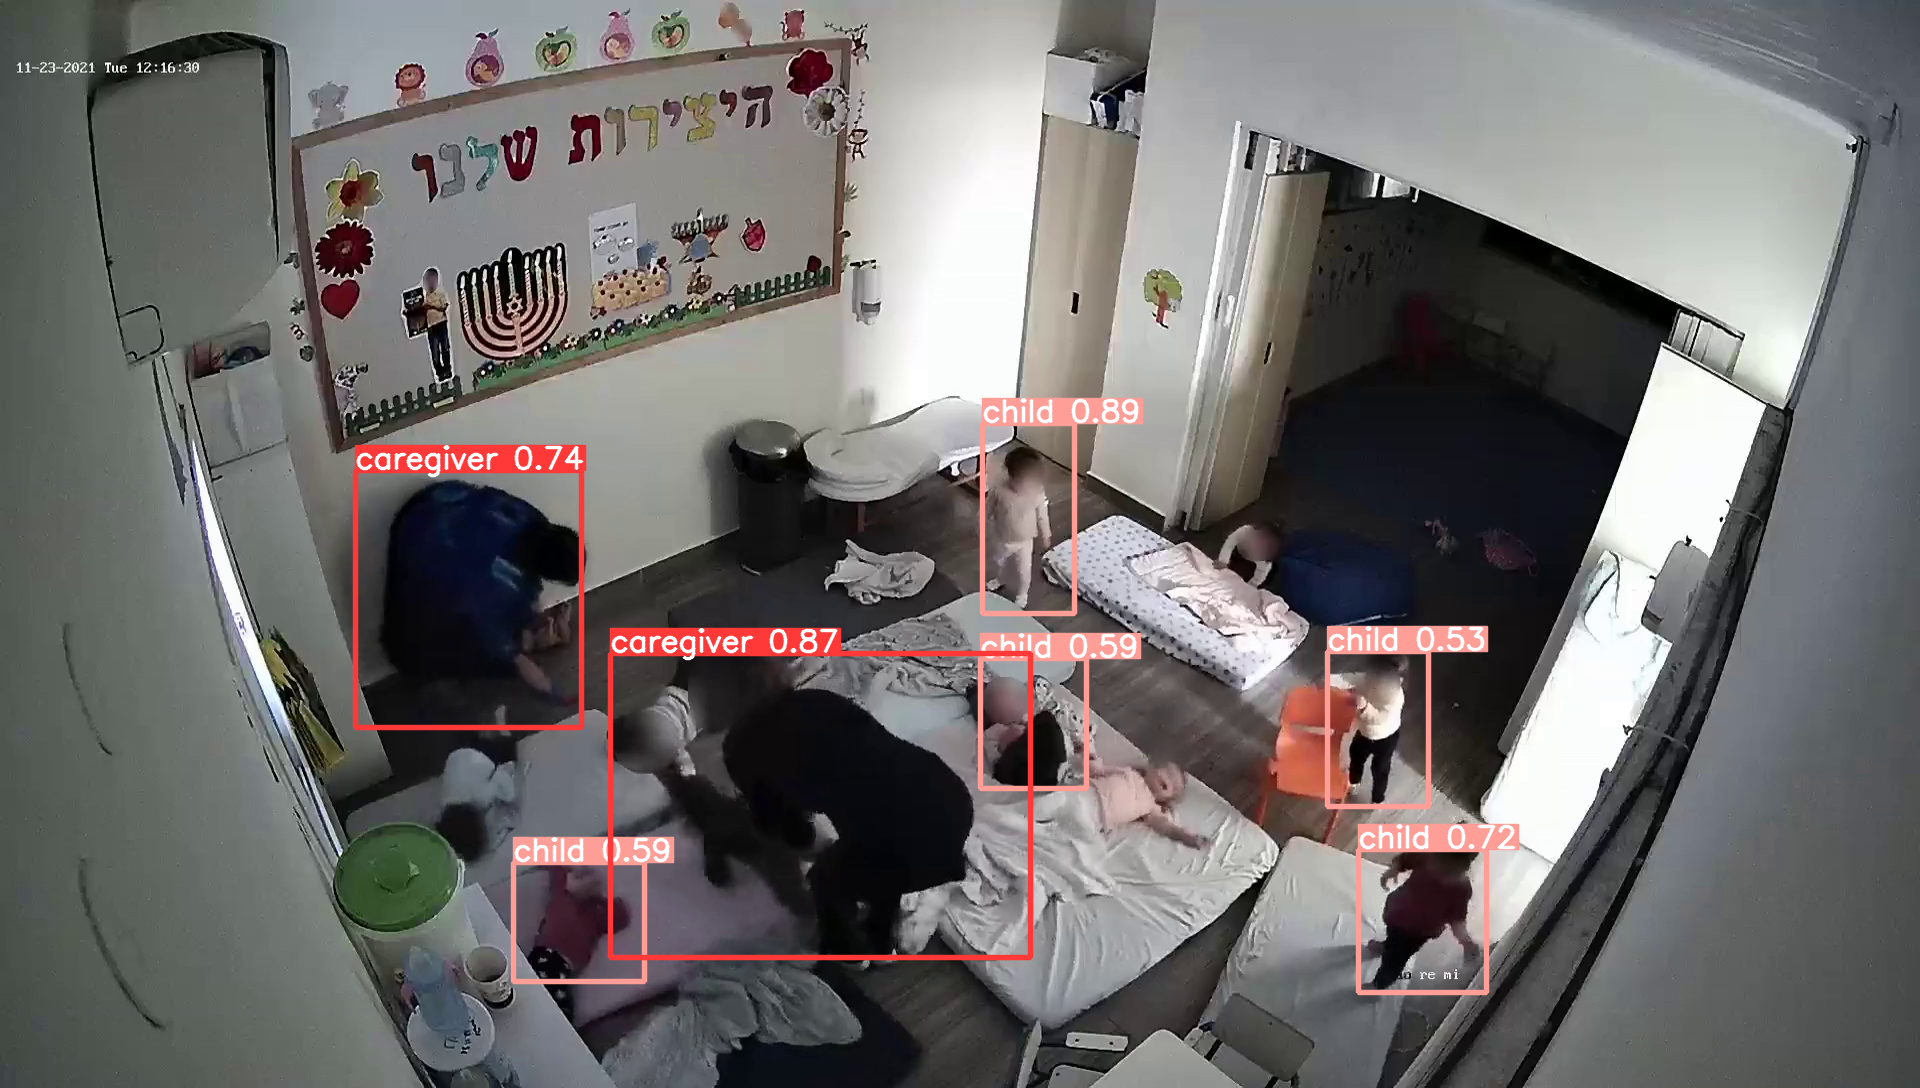

In [ ]:

display.Image(filename='/content/yolov5/runs/detect/exp2/G1179__147__0-27__0-32__fix_anonymized__frame-6.png', width=600)

In [ ]:
!python val.py --data /content/new_data_yaml --weights '/content/yolov5/runs/train/child_detector2/weights/best.pt' --imgsz 416 --conf-thres 0.5 

val: data=/content/new_data_yaml, weights=['/content/yolov5/runs/train/child_detector2/weights/best.pt'], batch_size=32, imgsz=416, conf_thres=0.5, iou_thres=0.6, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.0-242-gf40854b torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model Summary: 232 layers, 7249215 parameters, 0 gradients, 16.8 GFLOPs
val: Scanning '/content/data/labels/valid.cache' images and labels... 500 found, 0 missing, 0 empty, 2 corrupt: 100% 500/500 [00:00<?, ?it/s]
val: WARNING: /content/data/images/valid/G6921__441__0-08__0-16__fix_anonymized__frame-27.png: ignoring corrupt image/label: negative label values [         -1          -1          -1]
val: WARNING: /content/data/images/valid/G9303__441__0-08__0-16__fix_anonymized__frame-25.png: ignoring corrupt image/label: negati